# Lab 4 : DCASE: Трансформеры

## Set-up environment

In [1]:
#!pip install huggingface_hub transformers torch torchaudio pandas numpy matplotlib torchvision librosa accelerate pynvml ipywidgets

## Инициализация

In [1]:
import os
import random
import time
from typing import NoReturn, Optional
from dataclasses import dataclass, field

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset

import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F

from transformers import ASTFeatureExtractor, ASTForAudioClassification
from accelerate import Accelerator

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from pynvml import *

from IPython.display import Audio

### Выбираем устройство для расчетов (CPU или GPU)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Добиваемся максимальной воспроизводимости
Согласно данному мануалу: https://pytorch.org/docs/stable/notes/randomness.html

In [3]:
def init_random_state(random_state:int=0):
    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_state)
        torch.cuda.manual_seed_all(random_state)

In [4]:
random_state = 42

os.environ["PYTHONHASHSEED"] = str(random_state)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

init_random_state(random_state)

### Пути к файлам датасета

In [5]:
dcase_path = "/home/ext-zubakov-an@ad.speechpro.com/DCASE"

dcase_train_labels = "train.csv"
dcase_test_labels = "sample_submission.csv"

dcase_train_wavs = "audio_train/train"
dcase_test_wavs = "audio_test/test"

### Пути к сохраненным признакам

In [6]:
features_path = "/home/ext-zubakov-an@ad.speechpro.com/audio_analytics_labs/lab4/features"

test_features_audio = "test_audio_{model_name}_p{part}.pt"
dev_features_audio = "dev_audio_{model_name}_p{part}.pt"
train_features_audio = "train_audio_{model_name}_p{part}.pt"

## Загрузка меток

In [7]:
dcase_train = pd.read_csv(
    os.path.join(dcase_path, dcase_train_labels)
)
dcase_test = pd.read_csv(
    os.path.join(dcase_path, dcase_test_labels)
)

dcase_train.head(3)

,fname,label
0,8bcbcc394ba64fe85ed4.wav,Finger_snapping
1,00d77b917e241afa06f1.wav,Squeak
2,17bb93b73b8e79234cb3.wav,Electric_piano


### Получение списка событий

In [8]:
events = list(dcase_train["label"].unique())

for idx, event in enumerate(events):
    print(f"{idx:2}: {event}") 

 0: Finger_snapping
 1: Squeak
 2: Electric_piano
 3: Harmonica
 4: Snare_drum
 5: Trumpet
 6: Computer_keyboard
 7: Clarinet
 8: Laughter
 9: Tearing
10: Applause
11: Shatter
12: Knock
13: Bass_drum
14: Cowbell
15: Glockenspiel
16: Double_bass
17: Fireworks
18: Writing
19: Cough
20: Saxophone
21: Bark
22: Keys_jangling
23: Flute
24: Meow
25: Oboe
26: Cello
27: Hi-hat
28: Fart
29: Burping_or_eructation
30: Drawer_open_or_close
31: Microwave_oven
32: Acoustic_guitar
33: Tambourine
34: Gong
35: Violin_or_fiddle
36: Gunshot_or_gunfire
37: Telephone
38: Bus
39: Scissors
40: Chime


In [9]:
dcase_train = dcase_train.apply(
    lambda row: pd.Series(
        [row["fname"], row["label"], events.index(row["label"])],
        index=["fname", "label", "target"],
    ),
    axis=1,
)

dcase_train.head(3)

,fname,label,target
0,8bcbcc394ba64fe85ed4.wav,Finger_snapping,0
1,00d77b917e241afa06f1.wav,Squeak,1
2,17bb93b73b8e79234cb3.wav,Electric_piano,2


In [10]:
fnames = dcase_train["fname"]
targets = dcase_train["target"]

fnames_train, fnames_dev, targets_train, targets_dev = train_test_split(
    fnames,
    targets,
    test_size=0.15,
    random_state=random_state,
    stratify=targets,
)

fnames_train = np.stack(fnames_train)
targets_train = np.array(targets_train)

fnames_dev = np.stack(fnames_dev)
targets_dev = np.array(targets_dev)

print(f"""
Src set:
    fnames count:  {len(fnames)}
    targets count: {len(targets)}

Train set:
    fnames count:  {len(fnames_train)}
    targets count: {len(targets_train)}
    Total classes: {len(np.unique(targets_train))}

Dev set:
    fnames count:  {len(fnames_dev)}
    targets count: {len(targets_dev)}
    Total classes: {len(np.unique(targets_dev))}
""")


Src set:
    fnames count:  5683
    targets count: 5683

Train set:
    fnames count:  4830
    targets count: 4830
    Total classes: 41

Dev set:
    fnames count:  853
    targets count: 853
    Total classes: 41



In [11]:
fnames_test = dcase_test["fname"].to_numpy()
targets_test = torch.empty(fnames_test.shape[0])

print(f"""
Test set:
    fnames.length:  {len(fnames_test)}
    targets.length: {len(targets_test)}
""")


Test set:
    fnames.length:  3790
    targets.length: 3790



### Орисовка кривых обучения

In [12]:
def draw_learning_curves(dev_loss, dev_score, train_loss, train_score):
    epochs_count = len(dev_loss)
    epochs = range(1, epochs_count+1)

    fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

    xticks = range(1, epochs_count+1, epochs_count // 10) if epochs_count > 10 else epochs

    # draw loss
    ax_top.plot(epochs, train_loss, "r", label="обучающая")
    ax_top.plot(epochs, dev_loss, "b", label="валидационная")

    ax_top.set(
        title="Функция потерь",
        xlabel="Номер эпохи",
        ylabel="Значение функции потерь",
        ylim=[0, max(max(train_loss), max(dev_loss)) + 1],
    )
    ax_top.legend(
        title="Выборка",
    )
    ax_top.grid()

    # draw score
    ax_bottom.plot(epochs, train_score, "r", label="обучающая")
    ax_bottom.plot(epochs, dev_score, "b", label="валидационная")

    ax_bottom.set(
        title="F1-метрика",
        xlabel="Номер эпохи",
        ylabel="F1",
        xticks=xticks,
        ylim=[0, 1],
    )
    ax_bottom.legend(
        title="Выборка",
    )
    ax_bottom.grid()

    fig.suptitle("Кривые обучения")

    plt.show()

### Отрисовка спектрограмм

In [13]:
def draw_spectrogram(specgram, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    cmap = "viridis"

    img = ax.imshow(
        specgram.cpu(),
        origin="lower",
        aspect="auto",
        cmap=cmap,
    )
    ax.set(title=title or "Spectrogram")
    ax.label_outer()

    fig.colorbar(img, ax=ax, format="%+2.f dB")
    plt.show()

## Подготовка данных

### Аугментация

In [14]:
class FeatureAugmentation(nn.Module):
    def __init__(self, *, max_proportion:float=0.3, feature_len:int=1024):
        super().__init__()

        self.time_masking = T.TimeMasking(
            time_mask_param=2147483647, # max Int32
            iid_masks=False,
            p=max_proportion,
        )
        self.freq_masking = T.FrequencyMasking(
            freq_mask_param=max_proportion*feature_len,
        )

        self.eval()

    def forward(self, spec:torch.Tensor) -> list:
        augmented = self.freq_masking(
            self.time_masking(spec)
        )

        return augmented

In [117]:
def mixin(waveform, noise, snr_db:int=15):
    """ create mixin """
    snr_dbs = torch.tensor([snr_db])

    target_len = waveform.shape[1]
    if noise.shape[1] > target_len:
        noise = noise[:, : target_len]

    elif noise.shape[1] != target_len:
        pad_len = target_len - noise.shape[1]

        before = torch.randint(pad_len, (1,))
        after = pad_len - before

        noise = nn.functional.pad(noise, (before, after, 0, 0))

    return F.add_noise(waveform, noise, snr_dbs)

### Извлечение признаков

In [15]:
class FeatureExtractor(nn.Module):
    def __init__(self, *, sample_rate:int, need_augment:bool=False, max_proportion:float=0.3):
        super().__init__()

        self._sample_rate = sample_rate
        self._need_augment = need_augment

        self._ast_feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

        if self._need_augment:
            self.augmentation = FeatureAugmentation(max_proportion=max_proportion)

        self.eval()

    def forward(self, waveform:torch.Tensor, need_augment:Optional[bool]=None) -> list:
        if need_augment is None:
            need_augment = self._need_augment

        if need_augment and not self._need_augment:
            raise ArgumentError(
                "You should initialise `FeatureExtractor` with `need_augment=True` " + \
                "if you wand to use feature augmentation"
            )

        inputs = self._ast_feature_extractor(waveform[0], sampling_rate=self._sample_rate, padding="max_length", return_tensors="pt")
        feature = inputs.input_values

        if need_augment:
            feature = self.augmentation(feature)

        return feature

### Параметры извлечения признаков

In [16]:
# features parameters
@dataclass
class FeatureConfig:
    sample_rate : int
    max_proportion : float
    stretch_rate: float

In [17]:
feature_config = FeatureConfig(
    sample_rate=16_000,
    max_proportion=0.3,
    stretch_rate=0.3,
)
feature_config

FeatureConfig(sample_rate=16000, max_proportion=0.3, stretch_rate=0.3)

#### Демонстрация

In [18]:
need_demo = True

In [ ]:
feature_extractor = None

File: 'ab24201da80777f25193.wav', Label: Drawer_open_or_close


Duration: 1.22s, Sample Rate: 16000 Hz


Noise: '10794ef08bbfda045605.wav'


Duration: 7.0s, Sample Rate: 16000 Hz


Mixin, SNR: tensor([15]) dB:




Features:
Feature shape: torch.Size([1, 1024, 128])


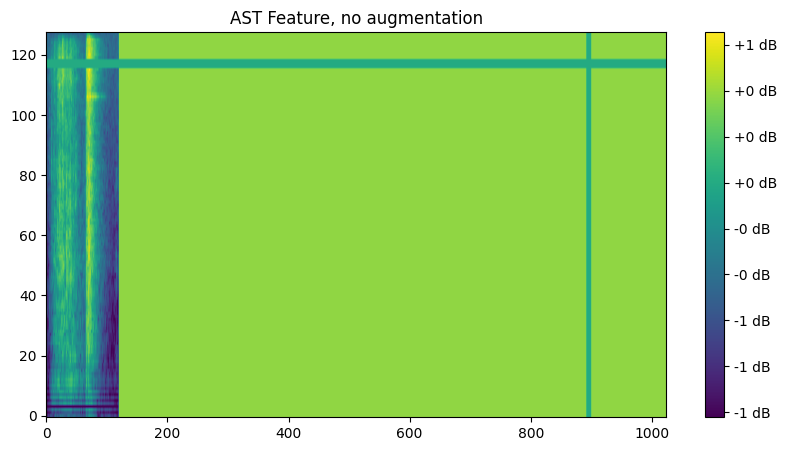



File: 'ecd8528189b82ef269ad.wav', Label: Microwave_oven


Duration: 1.56s, Sample Rate: 16000 Hz


Noise: '3301e288639cac559eb0.wav'


Duration: 2.5s, Sample Rate: 16000 Hz


Mixin, SNR: tensor([15]) dB:




Features:
Feature shape: torch.Size([1, 1024, 128])


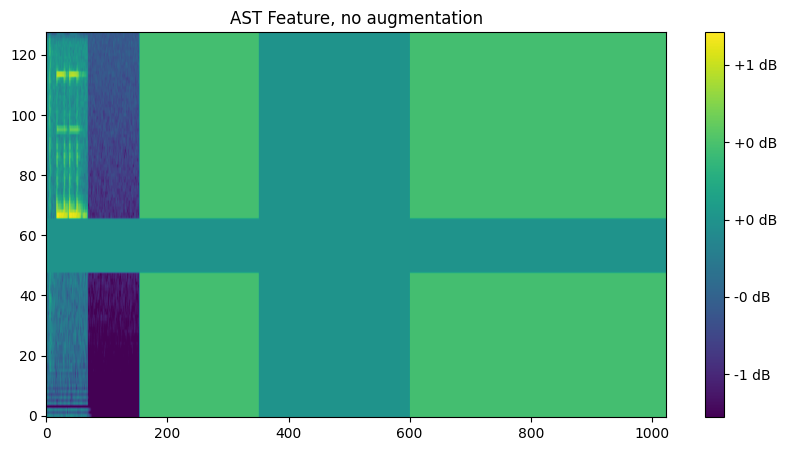

In [103]:
if need_demo:
    sample_rate = 16_000

    if feature_extractor is None:
        feature_extractor = FeatureExtractor(
            sample_rate=sample_rate,
            need_augment=True,
            max_proportion=feature_config.max_proportion,
        )

    for _ in range(2):
        sample = dcase_train.sample(2).to_numpy()
    
        filename = sample[0][0]
        label = sample[0][1]

        print(f"File: '{filename}', Label: {label}")
        waveform, sample_rate = torchaudio.load(os.path.join(dcase_path, dcase_train_wavs, filename))

        display(Audio(waveform[0], rate=sample_rate))
        print(f"Duration: {waveform.shape[1] / sample_rate}s, Sample Rate: {sample_rate} Hz", end="\n\n\n")

        noise_filename = sample[1][0]
        print(f"Noise: '{noise_filename}'")
        noise, noise_rate = torchaudio.load(os.path.join(dcase_path, dcase_train_wavs, noise_filename))

        display(Audio(noise[0], rate=noise_rate))
        print(f"Duration: {noise.shape[1] / noise_rate}s, Sample Rate: {noise_rate} Hz", end="\n\n\n")

        mixin_waveform = mixin(waveform, noise)

        print(f"Mixin, SNR: {snr_dbs} dB:")
        display(Audio(mixin_waveform[0], rate=sample_rate))

        print("\n\nFeatures:")

        feature = feature_extractor(waveform)

        print(f"Feature shape: {feature.shape}")
        draw_spectrogram(feature[0].T, title=f"AST Feature, no augmentation")

        print("\n")

#### Извлечение признаков

In [93]:
model_name = "AST_mixin"

In [94]:
need_extract_features = False

for filename in [train_features_audio]:
    path = \
        os.path.join(features_path, filename)\
            .replace("{model_name}", str(model_name))\
            .replace("{part}", "1")

    print(path)
    if not os.path.isfile(path):
        need_extract_features = True
        break

if need_extract_features:
    print("Features not found, extract them")
else:
    print("Features found")

/home/ext-zubakov-an@ad.speechpro.com/audio_analytics_labs/lab4/features/train_audio_AST_mixin_p1.pt
Features not found, extract them


In [25]:
features_path
train_features_audio

'train_audio_{model_name}_p{part}.pt'

In [118]:
max_features_in_file = 20_000

if need_extract_features:
    feature_extractor = FeatureExtractor(
        sample_rate=feature_config.sample_rate,
        need_augment=True,
        max_proportion=feature_config.max_proportion,
    )

for fnames, targets, wavdir, name_template, with_targets, need_augment in [
    (fnames_train, targets_train, dcase_train_wavs, train_features_audio, True,  True),
    #(fnames_dev,   targets_dev,   dcase_train_wavs, dev_features_audio,   True,  False),
    #(fnames_test,  targets_test,  dcase_test_wavs,  test_features_audio,  False, False),
]:
    if not need_extract_features:
        break

    features_fname = name_template.replace("{model_name}", str(model_name))
    features_filepath = os.path.join(features_path, features_fname)

    part = 1

    features_path_with_part = features_filepath.replace("{part}", str(part))
    targets_path_with_part = features_filepath.replace("{part}", f"{part}_targets")

    if os.path.isfile(features_path_with_part):
        continue

    features_list = []
    targets_list = []

    #fnames = np.hstack([fnames, fnames])
    #targets = np.hstack([targets, targets])

    for idx, (fname, target) in tqdm(enumerate(zip(fnames, targets))):
        wavpath = os.path.join(dcase_path, wavdir, fname)
        waveform, sample_rate = torchaudio.load(wavpath)

        if waveform.shape[1] == 0:
            continue

        sample = dcase_train.sample().to_numpy()
        noise_fname = sample[0][0]
        noise_path = os.path.join(dcase_path, wavdir, noise_fname)
        noise, _ = torchaudio.load(noise_path)

        try:
            waveform = mixin(waveform, noise)
        except:
            print(waveform.shape)
            print(noise.shape)
            raise

        if sample_rate != feature_config.sample_rate:
            waveform = torchaudio.functional.resample(
                waveform,
                sample_rate,
                feature_config.sample_rate
            )

        features = feature_extractor(waveform, need_augment=need_augment)

        features_list.extend([ f.cpu() for f in features ])

        if with_targets:
            targets_list.extend([ target ] * len(features))

        if len(features_list) == max_features_in_file or idx == len(fnames) - 1:
            torch.save(features_list, features_path_with_part)

            if with_targets:
                targets = torch.tensor(targets_list, dtype=torch.long)
                torch.save(targets, targets_path_with_part)

            print(f"Saved as '{features_path_with_part}'{' with targets' if with_targets else ''}")

            features_list = []
            targets_list = []

            part = part + 1
            features_path_with_part = features_filepath.replace("{part}", str(part))
            targets_path_with_part = features_filepath.replace("{part}", f"{part}_targets")

        found_empty = False

4830it [00:39, 122.90it/s]

Saved as '/home/ext-zubakov-an@ad.speechpro.com/audio_analytics_labs/lab4/features/train_audio_AST_mixin_p1.pt' with targets


## Загрузка признаков

### Подготовка датасета

In [119]:
class EventsDataset(Dataset):
    """Events Dataset"""

    def __init__(self, path:str, file_mask:str) -> NoReturn:
        """Initialize dataset."""
        self._path = os.path.join(path, file_mask)

        self._features = None
        self._targets = None
        self._map_item = None
        self._idx_shift = None

        self._calc_idx_map()

    def _calc_idx_map(self):
        self._idx_map = []
        self._length = 0

        part = 1
        features_path = self._path.replace("{part}", str(part))
        targets_path = self._path.replace("{part}", f"{part}_targets")

        with_targets = os.path.isfile(targets_path)
        
        while os.path.isfile(features_path):
            targets = None

            if with_targets:
                targets = torch.load(targets_path)
            else:
                features = torch.load(features_path)
                targets = torch.empty(len(features))

            self._idx_map.append({
                "start"   : self._length,
                "end"     : self._length + targets.shape[0] - 1,
                "features": features_path,
                "targets" : targets_path if with_targets else None,
            })

            self._length = self._length + targets.shape[0]

            part = part + 1
            features_path = self._path.replace("{part}", str(part))
            targets_path = self._path.replace("{part}", f"{part}_targets")

    def __len__(self) -> int:
        """Get dataset length."""
        return self._length

    def __getitem__(self, idx:int) -> torch.Tensor:
        """Get feature."""
        if idx >= self._length:
            raise ArgumentError("Index is greater than dataset length")

        self._load_files(idx)

        idx = idx - self._idx_shift

        features = self._features[idx]
        targets = self._targets[idx]

        return features.requires_grad_(), targets

    def _load_files(self, idx):
        if self._map_item is not None and self._map_item["start"] <= idx <= self._map_item["end"]:
            return

        del self._features
        del self._targets

        for item in self._idx_map:
            if item["start"] <= idx <= item["end"]:
                self._map_item = item

                self._idx_shift = item["start"]

                self._features = torch.load(item["features"])

                if item["targets"] is not None:
                    self._targets = torch.load(item["targets"])
                else:
                    self._targets = torch.empty(len(self._features))

                return

### Создание датасета

In [157]:
train_model_name = "AST_mixin"
dev_model_name = "AST"
test_model_name = "AST"

In [158]:
train_dataset = EventsDataset(
    features_path,
    train_features_audio.replace("{model_name}", str(train_model_name)),
)
dev_dataset = EventsDataset(
    features_path,
    dev_features_audio.replace("{model_name}", str(dev_model_name)),
)
test_dataset = EventsDataset(
    features_path,
    test_features_audio.replace("{model_name}", str(test_model_name)),
)

## Создание модели

### Конфигурация модели

In [159]:
@dataclass
class ModelConfig():
    epochs : int

    train_batch : int
    dev_batch   : int
    test_batch  : int

    learning_rate : float
    weight_decay  : float
        
    initial_dropout : float
    dropout         : float

    optimizer : torch.optim.Optimizer
    criterion : object

    gradient_accumulation_steps : int

Параметры отсюда: https://arxiv.org/pdf/2104.01778.pdf

In [160]:
config = ModelConfig(
    epochs=5,

    train_batch=4,
    dev_batch=32,
    test_batch=32,

    learning_rate=0.000001,
    weight_decay=0.2,
        
    initial_dropout=0,
    dropout=0.3,

    gradient_accumulation_steps=3,

    optimizer=optim.AdamW,
    criterion=nn.CrossEntropyLoss,
)
config

ModelConfig(epochs=5, train_batch=4, dev_batch=32, test_batch=32, learning_rate=1e-06, weight_decay=0.2, initial_dropout=0, dropout=0.3, optimizer=<class 'torch.optim.adamw.AdamW'>, criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, gradient_accumulation_steps=3)

#### Подготовка данных

In [161]:
init_random_state(random_state)

dev_dataloader = DataLoader(
    dev_dataset,
    batch_size=config.dev_batch,
    shuffle = False,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=config.test_batch,
    shuffle = False,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.train_batch,
    shuffle = True,
)

#### Модель

In [ ]:
#ast = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
#ast

In [127]:
class DcaseNet(nn.Module):
    """Neural network."""

    def __init__(self) -> NoReturn:
        """Initialize neural network."""
        super().__init__()

        self.ast = ast

        #self.classifier = nn.Sequential(
        #    nn.Linear(768, 41),
        #)

        self.ast.classifier.dense = nn.Linear(768, 41)

    def forward(self, x) -> torch.Tensor:
        """Defines the computation performed at every call."""
        x = self.ast(x)
        #x = self.classifier(x)

        return x.logits
        #return F.sigmoid(x.logits)

In [ ]:
#net = DcaseNet()

In [141]:
#net = torch.load("ast_2_adamw.model")

In [162]:
optimizer = config.optimizer(net.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion = config.criterion()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3,4,6,8], gamma=0.5)

def score_fn(y_true, y_pred):
    return f1_score(y_true, y_pred, average="weighted", zero_division=0)

In [163]:
#accelerator = Accelerator(
#    gradient_accumulation_steps=config.gradient_accumulation_steps,
#)

#net, optimizer, train_dataloader, scheduler = accelerator.prepare(
#    net, optimizer, train_dataloader, scheduler
#)

In [164]:
accelerator = Accelerator(
    gradient_accumulation_steps=config.gradient_accumulation_steps,
)

train_dataloader = accelerator.prepare(
    train_dataloader
)

#### Обучение

In [165]:
start_time = time.time()

train_loss = []
dev_loss = []

train_score = []
dev_score = []

for epoch in range(config.epochs):
    print(f'Epoch #{epoch+1}')

    # train
    net.train()

    loss_list = []
    predictions = []
    true_labels = []

    epoch_time = time.time()

    with torch.set_grad_enabled(True):
        for inputs, targets in train_dataloader:
            with accelerator.accumulate(net):
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                predictions.append(outputs.argmax(-1))
                true_labels.append(targets)
                loss_list.append(loss.item())

                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()

    scheduler.step()

    y_true = torch.hstack(true_labels).numpy(force=True)
    y_pred = torch.hstack(predictions).numpy(force=True)
    score = score_fn(y_true, y_pred)

    train_loss.append(np.mean(loss_list).item())
    train_score.append(score)

    print(f"[train] mean loss: {train_loss[-1]:.2f}")
    print(f"[train] F1:        {score:.2f}")
    print(f"Epoch time: {(time.time() - epoch_time):.2f} seconds", end="\n\n")

    # evaluate
    net.eval()

    loss_list = []
    predictions = []
    true_labels = []

    eval_time = time.time()

    with torch.set_grad_enabled(False):
        for inputs, targets in dev_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net(inputs)

            predictions.append(outputs.argmax(axis=1))
            true_labels.append(targets)

            targets = targets.to(device)

            loss = criterion(outputs, targets)

            loss_list.append(loss.item())

    y_true = torch.hstack(true_labels).numpy(force=True)
    y_pred = torch.hstack(predictions).numpy(force=True)
    score = score_fn(y_true, y_pred)

    dev_loss.append(np.mean(loss_list))
    dev_score.append(score)

    print(f"[dev] mean loss: {dev_loss[-1]:.2f}")
    print(f"[dev] F1:        {score:.2f}")
    print(f"Evaluation time: {(time.time() - eval_time):.2f} seconds", end="\n\n")

print(f"Total execution time: {(time.time() - start_time):.2f} seconds")

Epoch #1
[train] mean loss: 0.39
[train] F1:        0.90
Epoch time: 853.08 seconds

[dev] mean loss: 0.49
[dev] F1:        0.89
Evaluation time: 88.67 seconds

Epoch #2
[train] mean loss: 0.18
[train] F1:        0.96
Epoch time: 853.32 seconds

[dev] mean loss: 0.49
[dev] F1:        0.88
Evaluation time: 88.55 seconds

Epoch #3
[train] mean loss: 0.10
[train] F1:        0.98
Epoch time: 855.02 seconds

[dev] mean loss: 0.47
[dev] F1:        0.88
Evaluation time: 88.55 seconds

Epoch #4
[train] mean loss: 0.07
[train] F1:        0.99
Epoch time: 853.30 seconds

[dev] mean loss: 0.48
[dev] F1:        0.88
Evaluation time: 88.48 seconds

Epoch #5
[train] mean loss: 0.06
[train] F1:        0.99
Epoch time: 854.02 seconds

[dev] mean loss: 0.48
[dev] F1:        0.88
Evaluation time: 88.60 seconds

Total execution time: 4711.63 seconds


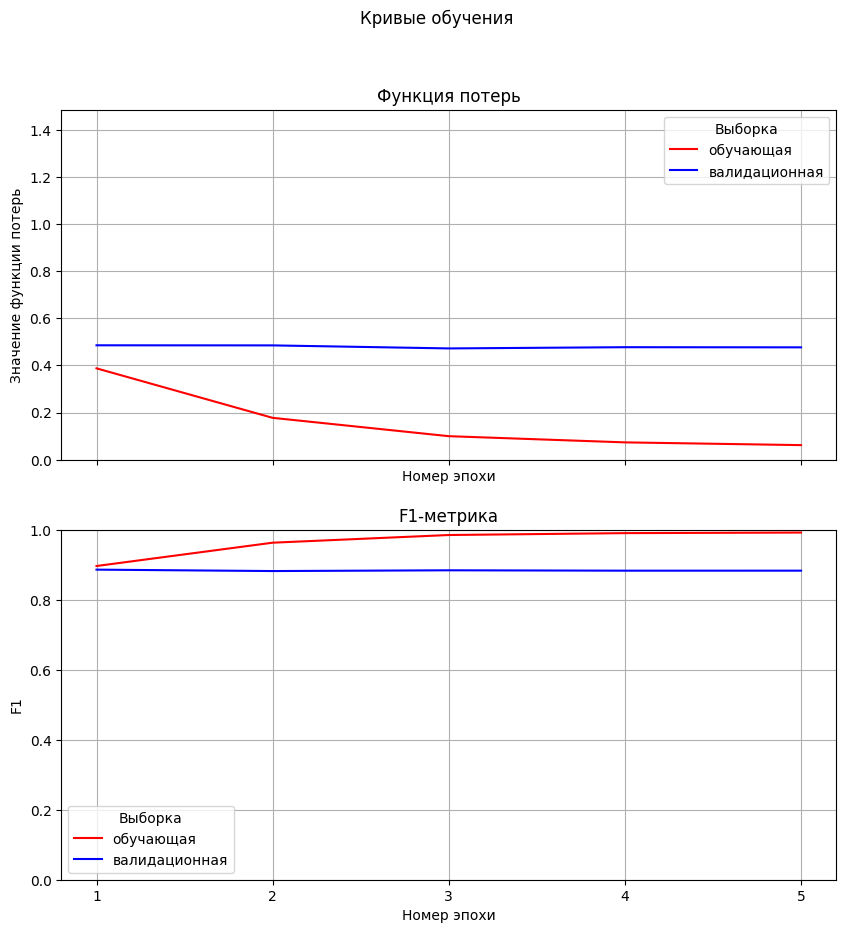

In [166]:
draw_learning_curves(dev_loss, dev_score, train_loss, train_score)

#### Инференс

In [167]:
torch.cuda.empty_cache()

In [168]:
start_time = time.time()

# evaluate
net.eval()

predictions = []

with torch.set_grad_enabled(False):
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        outputs = net(inputs)

        predictions.append(outputs.argmax(axis=1))

predictions = torch.hstack(predictions).cpu()

print(f"Total execution time: {(time.time() - start_time):.2f} seconds")

Total execution time: 394.43 seconds


In [169]:
dcase_test["target"] = predictions

result = dcase_test.apply(
    lambda row: pd.Series(
        [ row["fname"], events[row["target"]] ],
        index=["fname", "label"],
    ),
    axis=1,
)

result.to_csv("transformer_simple_aug_mixin.csv", index=False)
result

,fname,label
0,973a8b381d1875ebe120.wav,Knock
1,052e1cbeb4391d6af234.wav,Acoustic_guitar
2,16eb98d96319450e0949.wav,Knock
3,ff13c136c04f274229a5.wav,Knock
4,b458211304f7a14b29b2.wav,Cough
...,...,...
3785,959206e695c2ceed3d3b.wav,Bass_drum
3786,3624e1c6d306945d7ba9.wav,Bass_drum
3787,4a22b7dd3f519e2a9111.wav,Tearing
3788,a2c95e48acc6a3ec2696.wav,Double_bass


In [170]:
torch.save(net, "ast_2_simple_aug_mixin.model")